In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import tqdm

def check_model(model):
    print(model)
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"num_params: {num_params}")
    is_cuda = next(model.parameters()).is_cuda
    if is_cuda:
        device_name = torch.cuda.get_device_name(0)
        memory_allocated = torch.cuda.memory_allocated(0) / 1024 ** 3  #GB
        memory_cached = torch.cuda.memory_reserved(0) / 1024 ** 3  # GB
        print(f"memory on {device_name}")
        print(f"memory_allocated: {memory_allocated:.2f} GB")
        print(f"memory_cached: {memory_cached:.2f} GB")


CGAN: Conditional Generative Adversarial Network

这段代码定义了一个条件生成对抗网络（CGAN）的生成器和判别器。CGAN 是一种 GAN 变体，它允许生成器根据一个额外的条件变量来生成数据，这个条件变量可以是类别标签、颜色等。
### 生成器 (Generator)
生成器接受两个输入：一个随机噪声向量 `noise` 和一个类别标签向量 `labels`。它将这些输入合并后通过一系列的线性层和激活函数来生成图像。
- **线性层和激活函数**：生成器包含几个线性层，每个层后面都跟着一个 Leaky ReLU 激活函数。Leaky ReLU 是一种改进的 ReLU 激活函数，它在输入为负时提供了一个小的斜率，防止神经元死亡。
- **标签嵌入**：生成器使用一个嵌入层（`self.label_emb`）来将类别标签转换为固定维度的向量。这有助于将类别信息整合到生成器中。
- **输出层**：生成器最后一个线性层将特征映射到图像的像素值范围（-1 到 1），并通过 `nn.Tanh()` 激活函数来确保输出在 (0, 1) 范围内。
- **输出形状**：最终输出是一个形状为 `[batch_size, 1, img_size, img_size]` 的张量，表示生成的图像。
### 判别器 (Discriminator)
判别器接受一个图像张量 `img` 和一个类别标签向量 `labels`，然后判断图像是否真实。
- **线性层和激活函数**：判别器包含几个线性层，每个层后面都跟着一个 Leaky ReLU 激活函数。
- **标签嵌入**：判别器也使用一个嵌入层（`self.label_emb`）来将类别标签转换为固定维度的向量。
- **输出层**：判别器的最后一个线性层输出一个标量，表示图像的真实性。这个输出通过 `nn.Sigmoid()` 激活函数，输出一个介于 0 和 1 之间的概率值，表示图像是否真实。
- **输出形状**：判别器的输出是一个形状为 `[batch_size, 1]` 的张量，表示每个图像的真实性概率。
### 总结
这段代码定义了一个简单的 CGAN，其中生成器根据类别标签生成图像，判别器则判断这些图像是否真实以及是否与给定的类别标签匹配。在训练过程中，生成器和判别器相互对抗，以提高生成器的生成质量和判别器的判断准确性。


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader

# 定义CGAN的生成器和判别器
class Generator(nn.Module):
    def __init__(self, latent_dim, num_classes, img_size):
        super(Generator, self).__init__()
        self.img_size = img_size
        self.label_emb = nn.Embedding(num_classes, num_classes)

        self.main = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, int(self.img_size**2)),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        gen_input = torch.cat((noise, self.label_emb(labels)), -1)
        img = self.main(gen_input)
        img = img.view(img.size(0), 1, self.img_size, self.img_size)
        return img

class Discriminator(nn.Module):
    def __init__(self, num_classes, img_size):
        super(Discriminator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)

        self.main = nn.Sequential(
            nn.Linear(img_size**2 + num_classes, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        d_in = torch.cat((img.view(img.size(0), -1), self.label_emb(labels)), -1)
        validity = self.main(d_in)
        return validity


In [3]:
# 训练CGAN生成手写数字
def train_cgan(device): 
    # 数据预处理
    transform = transforms.Compose([
        transforms.Resize(28),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
    dataset = MNIST(root='../../data', transform=transform, download=False)
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    # 超参数设置
    latent_dim = 100
    num_classes = 10
    lr = 0.0002
    b1 = 0.5
    b2 = 0.999

    # 初始化生成器和判别器
    generator = Generator(latent_dim, num_classes, 28).to(device)
    discriminator = Discriminator(num_classes, 28).to(device)
    check_model(generator)
    check_model(discriminator)

    # 定义损失函数和优化器
    adversarial_loss = nn.BCELoss()
    generator_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
    discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))
    
    g_losses = []
    d_losses = []
    losses_G_epoch=[]
    losses_D_epoch=[]

    # 训练
    num_epochs = 1 #200
    for epoch in range(num_epochs):
        for i, (imgs, labels) in enumerate(dataloader):
            batch_size = imgs.shape[0]
            
            # 训练判别器
            discriminator_optimizer.zero_grad()
            
            # 使用真实图像训练判别器
            real_imgs = imgs.to(device)
            real_labels = labels.to(device)
            real_validity = discriminator(real_imgs, real_labels)
            real_loss = adversarial_loss(real_validity, torch.ones_like(real_validity))
            
            # 使用生成图像训练判别器
            noise = torch.randn(batch_size, latent_dim, device=device)
            fake_labels = torch.randint(0, num_classes, (batch_size,), device=device)
            fake_imgs = generator(noise, fake_labels)
            fake_validity = discriminator(fake_imgs, fake_labels)
            fake_loss = adversarial_loss(fake_validity, torch.zeros_like(fake_validity))
            
            d_loss = 0.5 * (real_loss + fake_loss)
            d_losses.append(d_loss.item())
            d_loss.backward()
            discriminator_optimizer.step()
            
            # 训练生成器
            generator_optimizer.zero_grad()
            
            # 生成图像并训练生成器
            noise = torch.randn(batch_size, latent_dim, device=device)
            fake_labels = torch.randint(0, num_classes, (batch_size,), device=device)
            fake_imgs = generator(noise, fake_labels)
            fake_validity = discriminator(fake_imgs, fake_labels)
            g_loss = adversarial_loss(fake_validity, torch.ones_like(fake_validity))
            g_losses.append(g_loss.item())
            g_loss.backward()
            generator_optimizer.step()
            
            # if (i+1) % 100 == 0:
            #     print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}")
        
        # 记录损失值
        loss_G_epoch = sum(g_losses)/len(g_losses)
        losses_G_epoch.append(loss_G_epoch)
        loss_D_epoch = sum(d_losses)/len(d_losses)
        losses_D_epoch.append(loss_D_epoch)
        print(f"Epoch [{epoch+1}/{num_epochs}], Disc Loss: {loss_D_epoch:.4f}, Gen Loss: {loss_G_epoch:.4f}")

        
    # 保存生成器模型
    torch.save(generator.state_dict(), 'cgan_generator.pth')
    torch.save(discriminator.state_dict(), 'cgan_discriminator.pth')

    return g_losses, d_losses, losses_G_epoch, losses_D_epoch

Generator(
  (label_emb): Embedding(10, 10)
  (main): Sequential(
    (0): Linear(in_features=110, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=512, out_features=1024, bias=True)
    (6): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=1024, out_features=784, bias=True)
    (9): Tanh()
  )
)
num_params: 1492084
Discriminator(
  (label_emb): Embedding(10, 10)
  (main): Sequential(
    (0): Linear(in_features=794, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): Leaky

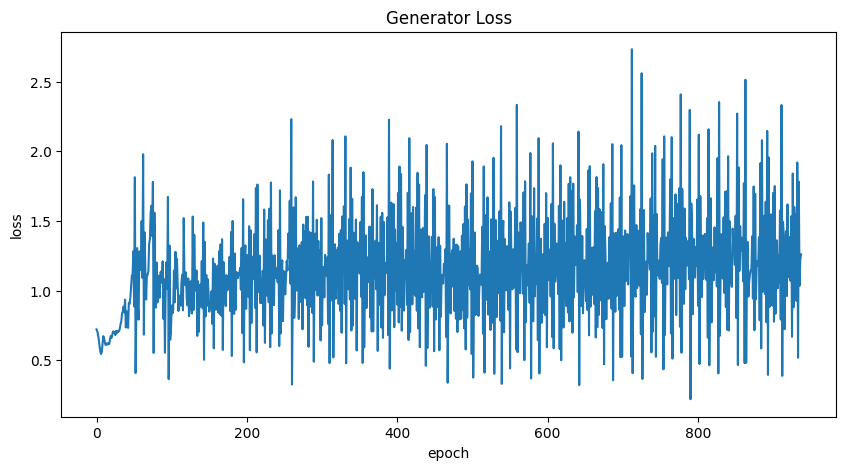

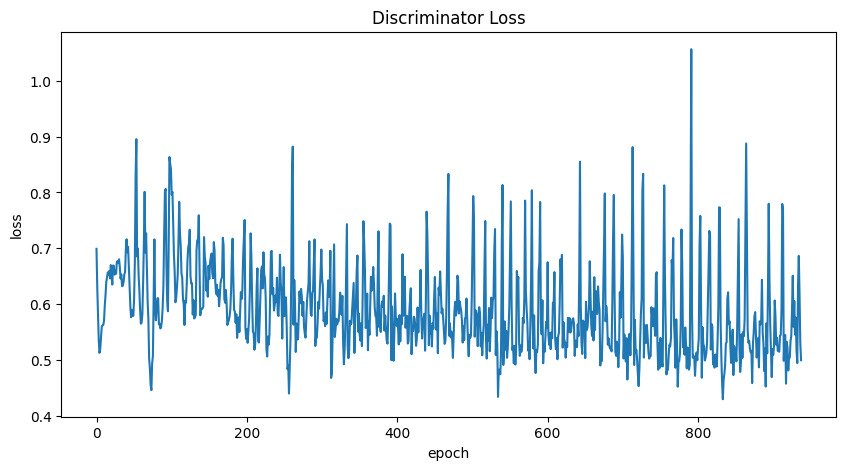

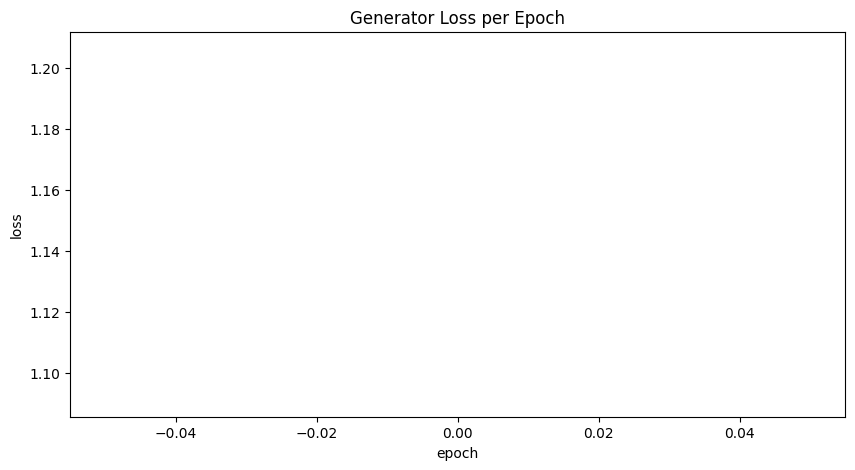

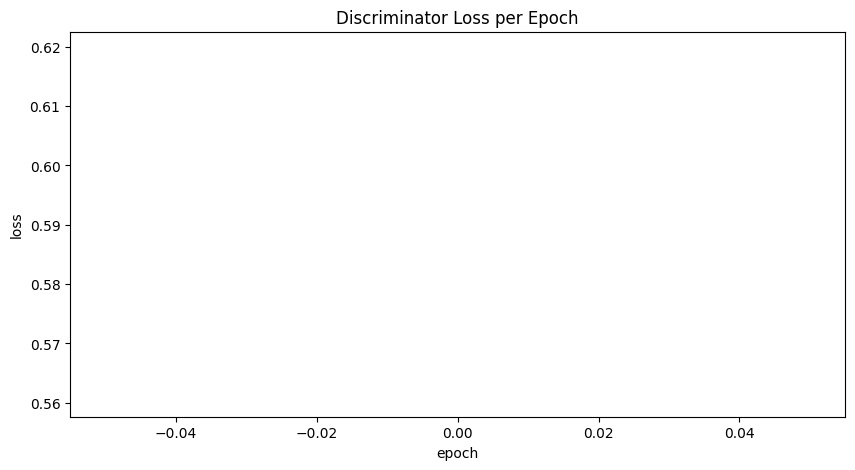

In [4]:
# plot loss for loss_G,loss_D,loss_G_epoch,loss_D_epoch

import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


g_losses, d_losses, losses_G_epoch, losses_D_epoch = train_cgan(device)

def plot_loss(loss_list, title):
    plt.figure(figsize=(10, 5))
    plt.plot(loss_list)
    plt.title(title)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

plot_loss(g_losses, 'Generator Loss')
plot_loss(d_losses, 'Discriminator Loss')
plot_loss(losses_G_epoch, 'Generator Loss per Epoch')
plot_loss(losses_D_epoch, 'Discriminator Loss per Epoch')


Generated images saved as generated_images.png


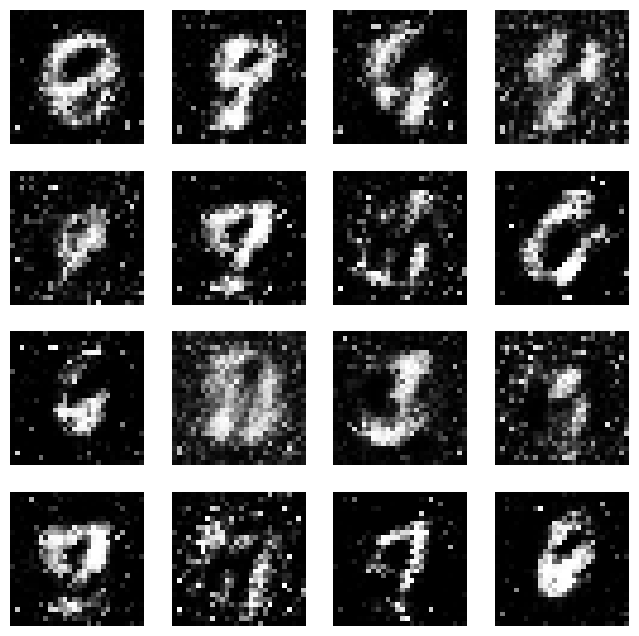

In [5]:
import torch
from torchvision.utils import save_image
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 加载训练好的生成器模型
generator = Generator(latent_dim=100, num_classes=10, img_size=28).to(device)
generator.load_state_dict(torch.load('cgan_generator.pth'))
generator.eval()

# 生成并保存图像
num_samples = 64
noise = torch.randn(num_samples, 100, device=device)
labels = torch.randint(0, 10, (num_samples,), device=device)
fake_images = generator(noise, labels)

# 保存生成的图像
save_image(fake_images, 'generated_images.png', nrow=8, normalize=True)
print('Generated images saved as generated_images.png')

# 显示生成的图像
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(fake_images[i].permute(1, 2, 0).detach().cpu().numpy(), cmap='gray')
    ax.axis('off')
plt.show()